In [2]:
import sys
import os
import tensorflow as tf
from platform import python_version 
import matplotlib.pyplot as plt
from skimage.transform import resize  
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np # linear algebra

from keras.applications import resnet50
# Step 1: set height and width of images

image_height = 224  # H
image_width = 224   # W
channels = 3
# Step 2: load ResNet50 Model

f_restnet = resnet50.ResNet50(weights='imagenet', input_shape=(image_height, image_width, channels)) 

f_restnet.summary() # prints the model architecture to the screen



Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                     

In [3]:
# Step 1: save file name and path
filename = 'images/Cat_Dog.jpg'  # Specify the path to your image file

# Step 2: load an image in PIL format
original_img = image.load_img(filename)

# Resize image to fit into the model - PIL format
resize_img = original_img.resize((image_height, image_width), resample=0)

# Convert the PIL image (width, height) to a NumPy array (height, width, channel)
npy_img = image.img_to_array(resize_img)

# Convert the image array into 4D Tensor (samples, height, width, channels) by adding an extra dimension to the axis 0.
input_img_tnsr = np.expand_dims(npy_img, axis=0)

# Create processed copy of the input image for ResNet50
processed_img = preprocess_input(input_img_tnsr.copy())

# Print the size/shape of the image data at each stage of the pre-processing
print("Original image size and shape = ", original_img.size)
print("Resized image size and shape = ", resize_img.size)
print("NumPy image size and shape = ", npy_img.shape)
print("Input tensor size and shape = ", input_img_tnsr.shape)
print("Processed Input tensor size and shape = ", processed_img.shape)



Original image size and shape =  (300, 168)
Resized image size and shape =  (224, 224)
NumPy image size and shape =  (224, 224, 3)
Input tensor size and shape =  (1, 224, 224, 3)
Processed Input tensor size and shape =  (1, 224, 224, 3)


input_img_tnsr[0] shape: (224, 224, 3)


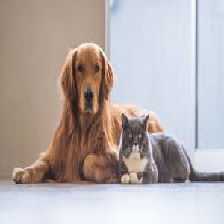

In [4]:


#1. print the shape of the first image data in the array.
print('input_img_tnsr[0] shape:', input_img_tnsr[0].shape)

#2. visualize a sample image 
image.array_to_img(input_img_tnsr[0])



In [5]:
# 1: predict objects in image using ResNet
predictions_resnet50 = f_restnet.predict(processed_img)

# 2: investigate top 10 and top 20 labels
label_resnet50 = decode_predictions(predictions_resnet50, top=10)


print("label_resnet50 = ", label_resnet50)

1/1 [==============================] - 2s 2s/step
label_resnet50 =  [[('n02100877', 'Irish_setter', 0.4767015), ('n02099601', 'golden_retriever', 0.32892954), ('n02088094', 'Afghan_hound', 0.074805915), ('n02102318', 'cocker_spaniel', 0.057342775), ('n02091831', 'Saluki', 0.04417373), ('n02102480', 'Sussex_spaniel', 0.004160319), ('n02100735', 'English_setter', 0.0022135552), ('n02101006', 'Gordon_setter', 0.002152696), ('n02099267', 'flat-coated_retriever', 0.0017337748), ('n02088466', 'bloodhound', 0.0010308861)]]


In [6]:


#1: Set the varible for number of masks, size of grid and proabaility of grid pixel being 1
N = 1000 # set numer of binary masks
s = 8   # set the size of the mask value for h & w 
pl = 0.5  # set probability of each element from in the mask being a one

#2. Create N grids of size s x s containing random 0's and 1's with equal proability.
grid = np.random.choice([0.5, 1], size=(N,s , s), p=[1-pl, pl])

#3. Print the shape of the 3D array generated.
print("Size of grid array: ",grid.shape)
unique, counts = np.unique(grid, return_counts=True)
p =  counts[1] / sum(counts)
print("probability of ones acieved = ",p)


Size of grid array:  (1000, 8, 8)
probability of ones acieved =  0.4998125


##### **Expected Output**:

<table>
    <tr>
        <td>
            Size of grid array
        </td>
        <td>
            (1000, 8, 8)
        </td>
    </tr>
    <tr>
        <td>
            probability of ones acieved
        </td>
        <td>
            <i>Value approching 0.5 ( will be random)</i>
        </td>
    </tr>
</table>

Shape of the first position in the grid: (8, 8)


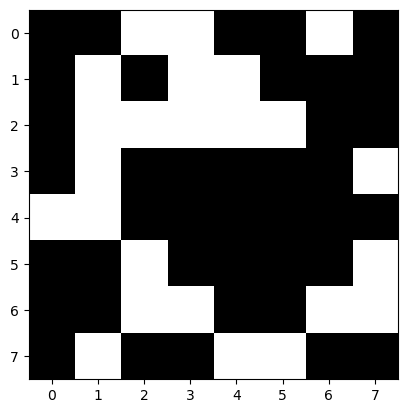

In [7]:


#1. print size of the first grid in the arrayof grids
print("Shape of the first position in the grid:", grid[0].shape) 

# change the gird to be viewed to see if they are all random and different.
plt.gray()
plt.imshow((grid[0]))




In [8]:
grid = grid.astype('float32')


#1: create array and print shape of array
M_i =  np.empty((N, image_height, image_width))

#2. Print size of array
print("masks shape",M_i.shape)



# Calucate cell size
cell_size = np.ceil(np.array((image_height,image_width)) / s)
up_size = (s + 1) * cell_size

for i in range(N):
    # Random shifts
    x = np.random.randint(0, cell_size[0])
    y = np.random.randint(0, cell_size[1])
    # Linear upsampling and cropping
    M_i[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect', anti_aliasing=True)[x:x + image_height, y:y + image_width]


masks shape (1000, 224, 224)


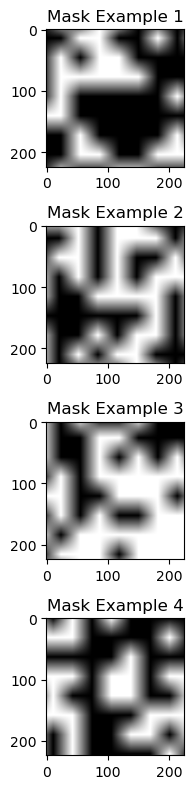

In [9]:

# Define the number of examples to display
number = 4

# Create subplots dynamically based on the number of examples
fig, axes = plt.subplots(4, number // 4, figsize=(15, 8))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Display examples of the masks generated in the array M_i
for i in range(number):
    axes[i].imshow(M_i[i], cmap='gray')
    axes[i].set_title(f'Mask Example {i + 1}')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [10]:
M_i = M_i.reshape(-1, image_height,image_width, 1)
#1. Print shape of M_i
print("shape of  M_i ",M_i.shape)

#2: pixelwise multiplication the masks and the input image 
Masked = input_img_tnsr * M_i

#print shape of masked images
print("Masked Images",Masked.shape)



shape of  M_i  (1000, 224, 224, 1)
Masked Images (1000, 224, 224, 3)


1/1 [==============================] - 1s 1s/step
Classification confidence for class tench is:  [2.1200293e-08]


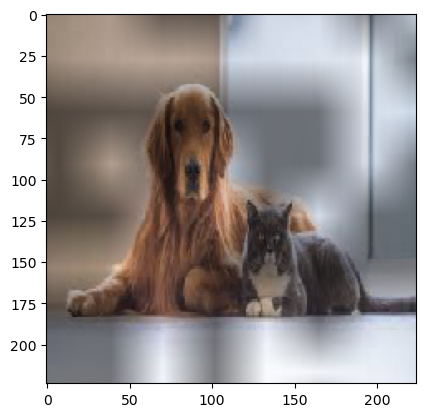

In [11]:
#Step 2: change input image

test_image = Masked[80]
plt.imshow(np.uint8(test_image))
test_image = np.expand_dims(test_image, axis=0)

def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

#Step 1: insert code that runs classifier

pred_test_image =  f_restnet.predict(test_image)
#Step 3: change class label

class_label = 0


print("Classification confidence for class", class_name(class_label),"is: ",pred_test_image[:,class_label])



In [12]:
batch_size = 100

preds = []
# Make sure multiplication is being done for correct axes

for i in range(0, N, batch_size):
    preds.append(f_restnet.predict(Masked[i:min(i+batch_size, N)]))
preds = np.concatenate(preds)


4/4 [==============================] - 8s 2s/step


In [13]:
preds.shape

(1000, 1000)

In [14]:
sal = preds.T.dot(M_i.reshape(N, -1)).reshape(-1, image_height,image_width)
sal = sal / N / pl

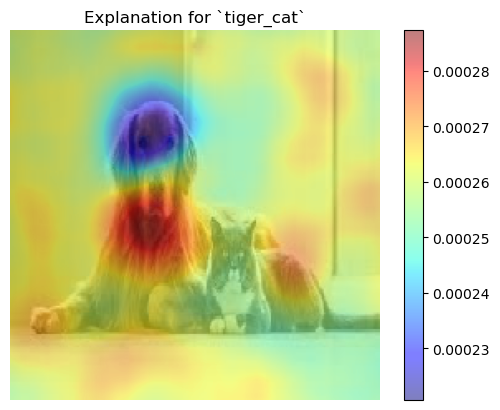

In [15]:
#Step 1: change class label code
class_idx = 282
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_img_tnsr[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

input_img_tnsr[0] shape: (224, 224, 3)
input_img_tnsr[0] shape: (224, 224, 3)


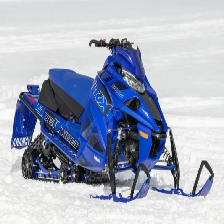

In [16]:
# Step 1: save file name and path
filename = 'images/snow mobile.PNG'  
# Step 2: load an image in PIL format
original_img = image.load_img(filename)
# Resize image to fit into the model - PIL format
resize_img = original_img.resize((image_height, image_width), resample=0)
# Convert the PIL image (width, height) to a NumPy array (height, width, channel)
npy_img = image.img_to_array(resize_img)
# Convert the image array into 4D Tensor (samples, height, width, channels) by adding an extra dimension to the axis 0.
input_img_tnsr = np.expand_dims(npy_img, axis=0)
# Create processed copy of the input image for ResNet50
processed_img = preprocess_input(input_img_tnsr.copy())
#1. print the shape of the first image data in the array.
print('input_img_tnsr[0] shape:', input_img_tnsr[0].shape)
#2. visualize a sample image 
image.array_to_img(input_img_tnsr[0])
#1. print the shape of the first image data in the array.
print('input_img_tnsr[0] shape:', input_img_tnsr[0].shape)
#2. visualize a sample image 
image.array_to_img(input_img_tnsr[0])



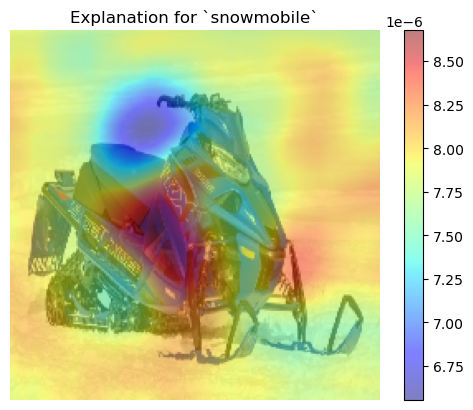

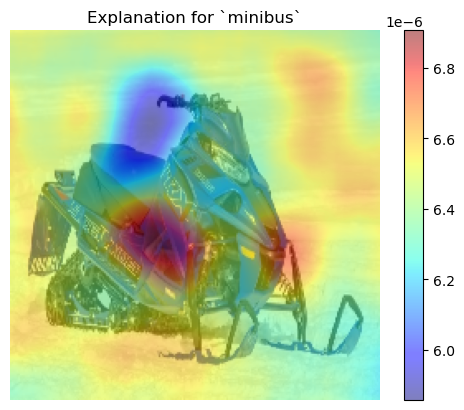

In [17]:
#Step 1: change class label code
class_idx = 802
plt.title('Explanation for `{0}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_img_tnsr[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()                    
#Step 1: change class label code
class_idx = 654
plt.title('Explanation for `{0}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_img_tnsr[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()       

input_img_tnsr[0] shape: (224, 224, 3)
input_img_tnsr[0] shape: (224, 224, 3)


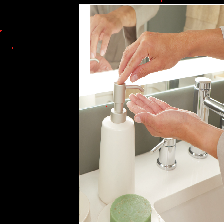

In [18]:
# Step 1: save file name and path
filename = 'images/Soap dispenser.PNG'  
# Step 2: load an image in PIL format
original_img = image.load_img(filename)
# Resize image to fit into the model - PIL format
resize_img = original_img.resize((image_height, image_width), resample=0)
# Convert the PIL image (width, height) to a NumPy array (height, width, channel)
npy_img = image.img_to_array(resize_img)
# Convert the image array into 4D Tensor (samples, height, width, channels) by adding an extra dimension to the axis 0.
input_img_tnsr = np.expand_dims(npy_img, axis=0)
# Create processed copy of the input image for ResNet50
processed_img = preprocess_input(input_img_tnsr.copy())
#1. print the shape of the first image data in the array.
print('input_img_tnsr[0] shape:', input_img_tnsr[0].shape)
#2. visualize a sample image 
image.array_to_img(input_img_tnsr[0])
#1. print the shape of the first image data in the array.
print('input_img_tnsr[0] shape:', input_img_tnsr[0].shape)
#2. visualize a sample image 
image.array_to_img(input_img_tnsr[0])
    

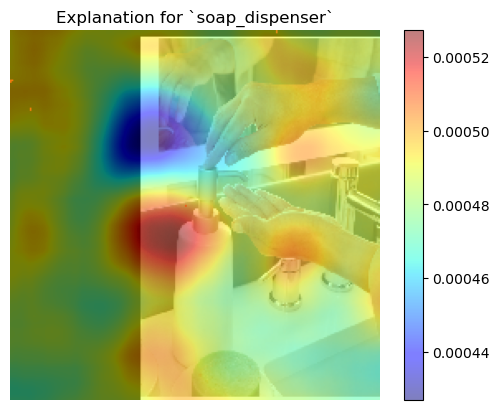

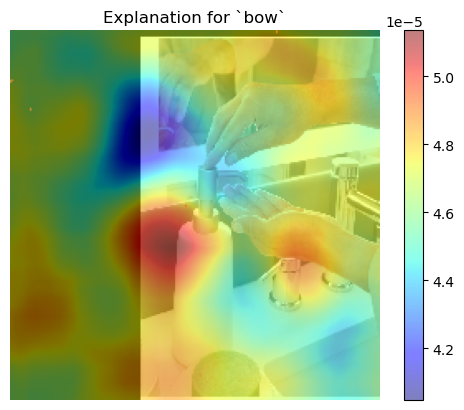

In [19]:
#Step 1: change class label code
class_idx = 804
plt.title('Explanation for `{0}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_img_tnsr[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()                    
#Step 1: change class label code
class_idx = 456
plt.title('Explanation for `{0}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_img_tnsr[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()   

input_img_tnsr[0] shape: (224, 224, 3)


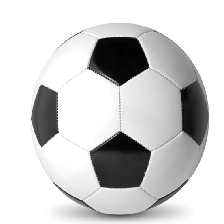

In [20]:
# Step 1: save file name and path
filename = 'images/soccer ball.PNG' 
# Step 2: load an image in PIL format
original_img = image.load_img(filename)
# Resize image to fit into the model - PIL format
resize_img = original_img.resize((image_height, image_width), resample=0)
# Convert the PIL image (width, height) to a NumPy array (height, width, channel)
npy_img = image.img_to_array(resize_img)
# Convert the image array into 4D Tensor (samples, height, width, channels) by adding an extra dimension to the axis 0.
input_img_tnsr = np.expand_dims(npy_img, axis=0)
# Create processed copy of the input image for ResNet50
processed_img = preprocess_input(input_img_tnsr.copy())
#1. print the shape of the first image data in the array.
print('input_img_tnsr[0] shape:', input_img_tnsr[0].shape)
#2. visualize a sample image 
image.array_to_img(input_img_tnsr[0])

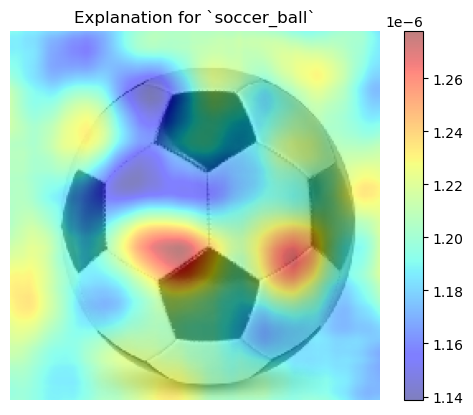

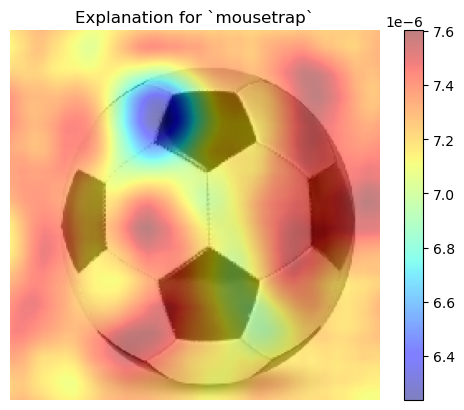

In [21]:
#Step 1: change class label code
class_idx = 805
plt.title('Explanation for `{0}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_img_tnsr[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()                    
#Step 1: change class label code
class_idx = 674
plt.title('Explanation for `{0}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_img_tnsr[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show() 

input_img_tnsr[0] shape: (224, 224, 3)


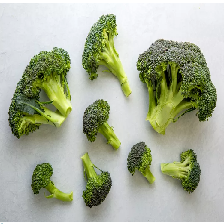

In [22]:
# Step 1: save file name and path
filename = 'images/brocolli.PNG'  
# Step 2: load an image in PIL format
original_img = image.load_img(filename)
# Resize image to fit into the model - PIL format
resize_img = original_img.resize((image_height, image_width), resample=0)
# Convert the PIL image (width, height) to a NumPy array (height, width, channel)
npy_img = image.img_to_array(resize_img)
# Convert the image array into 4D Tensor (samples, height, width, channels) by adding an extra dimension to the axis 0.
input_img_tnsr = np.expand_dims(npy_img, axis=0)
# Create processed copy of the input image for ResNet50
processed_img = preprocess_input(input_img_tnsr.copy())
#1. print the shape of the first image data in the array.
print('input_img_tnsr[0] shape:', input_img_tnsr[0].shape)
#2. visualize a sample image 
image.array_to_img(input_img_tnsr[0])


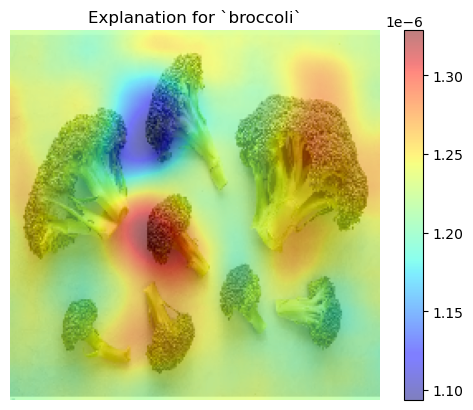

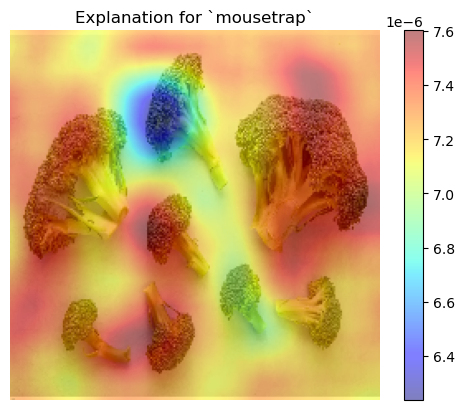

In [23]:
#Step 1: change class label code
class_idx = 937
plt.title('Explanation for `{0}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_img_tnsr[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()                    
#Step 1: change class label code
class_idx = 674
plt.title('Explanation for `{0}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_img_tnsr[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show() 

input_img_tnsr[0] shape: (224, 224, 3)


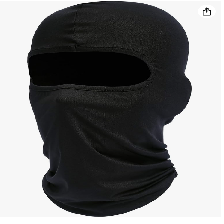

In [24]:
# Step 1: save file name and path
filename = 'images/ski mask.PNG'  
# Step 2: load an image in PIL format
original_img = image.load_img(filename)
# Resize image to fit into the model - PIL format
resize_img = original_img.resize((image_height, image_width), resample=0)
# Convert the PIL image (width, height) to a NumPy array (height, width, channel)
npy_img = image.img_to_array(resize_img)
# Convert the image array into 4D Tensor (samples, height, width, channels) by adding an extra dimension to the axis 0.
input_img_tnsr = np.expand_dims(npy_img, axis=0)
# Create processed copy of the input image for ResNet50
processed_img = preprocess_input(input_img_tnsr.copy())
#1. print the shape of the first image data in the array.
print('input_img_tnsr[0] shape:', input_img_tnsr[0].shape)
#2. visualize a sample image 
image.array_to_img(input_img_tnsr[0])


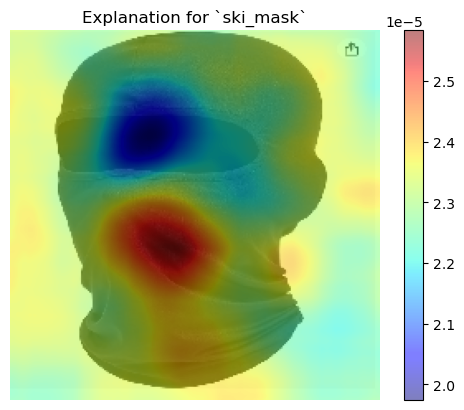

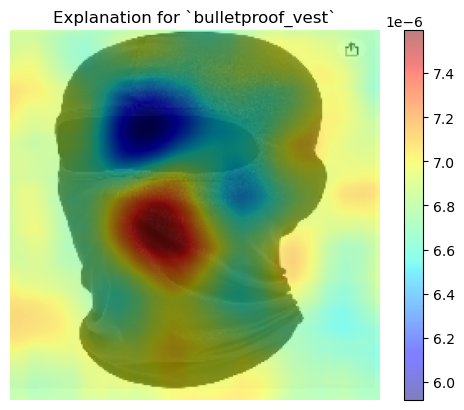

In [25]:
#Step 1: change class label code
class_idx = 796
plt.title('Explanation for `{0}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_img_tnsr[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()                    
#Step 1: change class label code
class_idx = 465
plt.title('Explanation for `{0}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_img_tnsr[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show() 